<a href="https://colab.research.google.com/github/Soubhagya0037/Neural-Style-Transfer/blob/main/Neural_Style_Transfer(Using_Adam).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are going to use TensorFlow 2.0. So, first of all, we need to install that

In [14]:
import os
import tensorflow as tf

# Importing Libraries

In [15]:
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import time

# Image Preprocessing

In [16]:
content_path="/content/Content_image.jpg"
style_path="/content/Painting_Style.jpg"

For Resizing the image

In [17]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

For displaying the image

In [18]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.imshow(image)
  if title:
    plt.title(title)

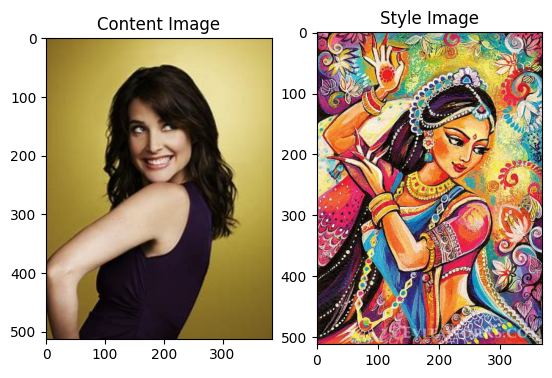

In [19]:
content_image = load_img(content_path)
style_image = load_img(style_path)
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# Loading the Model

VGG19 is a State-of-the-art image classifier. As in our case, we don’t want to classify images, so we will not use its final layers.
include_top=false means you don't want to include the final layers.

In [20]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80134624/80134624 [==============================] - 1s 0us/step


In [21]:
for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


we will take a layer from the final block of the model for content extraction as it represents the feature of the image well. In our case, we are taking the block5_conv4 layer

In [22]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2']
num_content_layers = len(content_layers)

As at each layer some of the other patterns are being detected therefore we will use multiple layers( one from each block) to extract the style information. In our case, we will be using [‘block1_conv1’, ‘block2_conv1’,’block3_conv1', ‘block4_conv1’, ‘block5_conv1’]

In [23]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
num_style_layers = len(style_layers)

# Model Building

vgg_layers, Creates a vgg model that returns a list of intermediate output values.

In [24]:
def vgg_layers(layer_names):
# Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

# Calculating Loss in NST

gram_matrix (used to compute the style loss)




*   The style_loss function, which keeps the generated image close to the local textures of the style reference image
*   The content_loss function, which keeps the high-level representation of the generated image close to that of the base image
*  The total_variation_loss function, a regularization loss which keeps the generated image locally-coherent.





In [25]:
style_weight = 1e-2
content_weight = 1e4
num_style_layers = len(style_layers)
num_content_layers = len(content_layers)


In [26]:
# Function to create a VGG model that returns a list of intermediate output values
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Function to calculate the Gram matrix for an input tensor
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style': style_dict}

In [27]:
# Style and content loss functions
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)
    loss = style_loss + content_loss
    return loss

# High-pass filter for image
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    return x_var, y_var

# Total variation loss function
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

In [28]:
# Create an instance of the model
extractor = StyleContentModel(style_layers, content_layers)


In [29]:
# Extract style and content targets
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Optimiser

In [30]:
# Optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Compute losses and update the model
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_loss(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    return loss

In [31]:
image = tf.Variable(content_image, dtype=tf.float32)

In [32]:
from IPython.display import display, clear_output

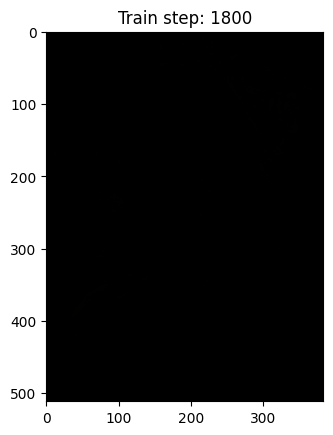

...........................................

KeyboardInterrupt: 

In [33]:
# Training loop with timing and visualization
start = time.time()
epochs = 100
steps_per_epoch = 50
step = 0

for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    clear_output(wait=True)
    plt.imshow(tf.squeeze(image.read_value(), axis=0) / 255.0)
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f} seconds".format(end - start))

have to disrupt because it was taking too much of the time

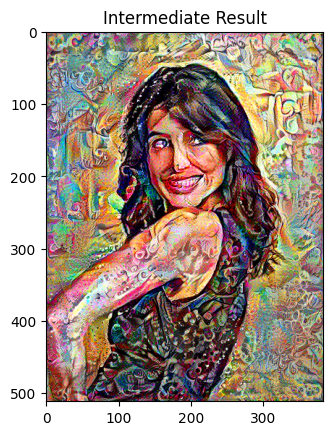

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to save and display the image
def save_and_display_image(image, filename):
    # Ensure the tensor values are in the range [0, 1]
    intermediate_image = tf.squeeze(image.read_value(), axis=0)
    intermediate_image = tf.clip_by_value(intermediate_image, 0.0, 1.0)

    # Convert the tensor to a numpy array and save it
    plt.imsave(filename, intermediate_image.numpy())

    # Display the image
    plt.imshow(intermediate_image)
    plt.title("Intermediate Result")
    plt.show()

# Save and display the current state of the image
save_and_display_image(image, "/content/intermediate_result.png")

